In [5]:
import numpy as np
import copy
import pickle

from scipy import ndimage
from BaselineRemoval import BaselineRemoval
import matplotlib.pyplot as plt
import os
from scipy import interpolate

plt.rcParams['figure.figsize'] = (20.0, 10.0)
# plt.rcParams['figure.figsize'] = (10.0, 5.0)
plt.rcParams['figure.dpi'] = 500

In [6]:
file_location = "../data/Raman_Mouse/corrected_4_wavenumbers/"
# file_location = "../data/Green_excitation/corrected_4_wavenumbers/"

filenames = np.load(f"{file_location}FileNames.npy")
with open(f"{'/'.join(file_location.split('/')[:-2])}/Sample_labels.pickle", 'rb') as f:
    labels = pickle.load(f)
labels = {l.split(".")[0]: val for l, val in labels.items()}

wavenumbers = np.load(f"{file_location}Wavenumbers.npy")
    
data = []
for f in filenames:
    x = np.load(f"{file_location}{f.split('.')[0]}.npy")
    data.append(((x.reshape(-1,x.shape[-1])).reshape(x.shape), labels[f.split(".")[0]]))

In [8]:
rng = np.random.default_rng()

class Kalman():    
    def __init__(self, X, grad, e, neighbourhood, photo_smoothness = 500, noise_smoothness = 2, correct_photo_appr_blacknoise=True):
        """
        noise_smoothness controls the amount of noise when set below zero, raman data will be seen as noise.
        high noise_smoothness means low noise (however a low number does not remove noise correctly)
        """
        
        self.X = X
        self.N_wavenumbers = self.X.shape[0]
        self.N_photo_appr = X.shape[1] - 1
        self.photo_smoothness = photo_smoothness
        self.noise_smoothness = noise_smoothness
        
        self.C = np.array([[1,1]] +
                           [[1,0]] * self.N_photo_appr)
        self.A = np.zeros((self.N_wavenumbers, 2, 2))
        self.A[:,0,0] = grad
        self.A[:,1,1] = 1
        
        if correct_photo_appr_blacknoise:
            self.e = np.array([e] * X.shape[1])
        else:
            self.e = np.array([e] + [0] * self.N_photo_appr)
            
        self.n = neighbourhood
        self.mu = np.empty((self.N_wavenumbers, 2))
        self.M = np.empty((self.N_wavenumbers, 2, 2))
        self.nu = np.empty((self.N_wavenumbers+1, 2))
        self.V = np.empty((self.N_wavenumbers+1, 2, 2))
        self.J = np.empty((self.N_wavenumbers, 2, 2))

        self.nu[0] = [X[0,0], 0]
        
        self.Sigma = np.diag(rng.standard_normal(1 + self.N_photo_appr))
        self.Gamma = np.diag(rng.standard_normal(2))
        self.V[0] = [[0, 0],
                     [0, 0]]
    
    @property
    def raw_data(self):
        return self.X, self.A[:,0,0]
    
    @raw_data.setter
    def raw_data(self, args):
        value, grad = args
        self.X = value
        self.nu[0] = [self.X[0,0], 0]
        self.A[:,0,0] = grad
        self.EM(1)
        
    def _filter_step(self, i):
        CV = self.C @ self.V[i]
        b = self.C @ self.nu[i] + self.e
        B = CV @ self.C.T + self.Sigma
        K = self.V[i] @ self.C.T @ np.linalg.inv(B)
        tmp = self.X[i] - b
        self.TEST = self.TEST[1:] + [tmp[1]]
#         self.TEST = (self.TEST + self.X[i,1] - b[1]) / 2
#         tmp[1] = (tmp[1] + self.TEST) / 2
#         tmp[1] = 
        self.mu[i] = self.nu[i] + K @ (tmp)
        self.M[i] = self.V[i] - K @ CV
#         self.tmp.append(tmp)

        # transition
        self.nu[i+1] = self.A[i] @ self.mu[i]
        self.V[i+1] = self.A[i] @ self.M[i] @ self.A[i] + self.Gamma # A = A.T
        self.nu[i+1,0] = min(min(self.X[max(0,i-self.n):min(self.N_wavenumbers,i+self.n)+1,0]) - self.e[0], self.nu[i+1,0])
        self.nu[i+1,1] = max(0, self.nu[i+1,1])

    def _smoother_step(self, i):
        self.J[i] = self.M[i-1] @ self.A[i] @ np.linalg.inv(self.V[i])
        self.M[i-1] += self.J[i] @ (self.M[i] - self.V[i]) @ self.J[i].T
        self.mu[i-1] += self.J[i] @ (self.mu[i] - self.nu[i])
        self.mu[i,0] = min(min(self.X[max(0,i-self.n):min(self.N_wavenumbers,i+self.n)+1,0]) - self.e[0], self.mu[i,0])
        self.mu[i,1] = max(0, self.mu[i,1])
    
    def kalman_filter(self):
#         self.tmp = []
        self.TEST = [0 for i in range(10)]
        for i in range(len(self.X)):
            self._filter_step(i)
#         tmp = np.array(self.tmp)
#         plt.plot(self.X[:,0]/20)
#         plt.plot(self.X[:,1]/20)
        
#         plt.plot(tmp[:,0], label='0')
#         plt.plot(tmp[:,1], label='1')
#         plt.legend()
#         plt.show()
                        
    def kalman_smoother(self):
        self.kalman_filter()
        for i in range(len(self.X)-1, 0, -1):
            self._smoother_step(i)
            
    def EM(self, n):
        for i in range(n):
            print(f"EM step {i}")
            self.kalman_smoother()
            E_z = self.mu
            E_zz = self.M + self.mu.reshape(-1,self.mu.shape[1],1) @ self.mu.reshape(-1,1,self.mu.shape[1])
            E_z_1z = (self.J @ self.M)[1:] + self.mu[:-1].reshape(-1,self.mu.shape[1],1) @ self.mu[1:].reshape(-1,1,self.mu.shape[1])
            
            self.nu[0] = E_z[0]
            self.V[0] = E_zz[0] - E_z[0].reshape(-1,1) @ E_z[0].reshape(1,-1)
            
            # skip nu_0, V_0, A and C
            self.Gamma = np.sum(E_zz[1:] - 
                                E_z_1z.transpose(0,2,1) @ self.A[:-1].transpose(0,2,1) - 
                                self.A[:-1] @ E_z_1z + 
                                self.A[:-1] @ E_zz[:-1] @ self.A[:-1].transpose(0,2,1),
                                0) / self.N_wavenumbers

            self.Sigma = (self.X.T @ self.X - 
                         self.C @ E_z.T @ self.X - 
                         self.X.T @ E_z @ self.C.T + 
                         np.sum(self.C @ E_zz @ self.C.T, 0)) / (self.N_wavenumbers + 1)
                        
            # make covarience diagonal
#             self.Sigma = np.diag(np.diag(self.Sigma)) 
#             self.Sigma[0,0] /= self.noise_smoothness
                        
#             self.Gamma = np.diag(np.diag(self.Gamma)) 
#             self.Gamma[0,0] /= 5
            c = (self.Gamma[0,0] + self.Gamma[1,1]) / self.photo_smoothness
            self.Gamma = np.diag([c, c*(self.photo_smoothness-1)])
            
            
def split_signal(img):
    """ 
    img consists of data and label
    
    artefact due to using previous points 
    
    """
    black_noise = 0
    n = 250
#     n = 85

    x = img[0].reshape(-1, img[0].shape[-1])

#     baseObj = BaselineRemoval(x[n])
#     Zhangfit_output = baseObj.ZhangFit()
#     poly2 = x[n] - Zhangfit_output
#     obj = Kalman(np.stack((x[n], poly2)).T, np.ones(poly2.shape), black_noise, neighbourhood=1, photo_smoothness=100, noise_smoothness = 2)
#     obj.EM(10)

    func = interpolate.UnivariateSpline(wavenumbers, 
                                        x[n],
                                        k=4, s=5e6)
    poly2 = func(wavenumbers)   
    
    error = (poly2-x[n])
    grad = np.abs(np.pad(error[1:] / error[:-1],(0, 1), 'edge')) < 1
    weight = np.array([int(x*y) + 1e-5  for x, y in zip(error > 0, grad)])
    weight[:250] = 1
    weight[-10:] = 1
    func = interpolate.UnivariateSpline(wavenumbers, 
                                        x[n],
                                        w=weight,
                                        k=4, s=1e6)    
    poly3 = func(wavenumbers)
    
    func = interpolate.UnivariateSpline(wavenumbers, 
                                        np.pad(poly3[1:] / poly3[:-1],(0, 1), 'edge'),
                                        k=4)
    grad = func(wavenumbers)
    obj = Kalman(np.stack((x[n], poly3)).T, grad, black_noise, neighbourhood=1, photo_smoothness=100, noise_smoothness = 2)
    obj.EM(10)
        
    raman = obj.mu[:,1]
    photo = obj.mu[:,0]
    grad2 = np.pad(photo[1:] / photo[:-1],(0, 1), 'edge')
    tmp = np.isclose(grad2, ndimage.gaussian_filter(grad2, 10), 0.001)
    
    
    # TODO find appropiate s
    func = interpolate.UnivariateSpline(wavenumbers, 
                                        photo,
                                        w = ~tmp+0.01,
                                        k=4, s=5e5)
    smooth_photo = func(wavenumbers)
    
    grad3 = np.pad(smooth_photo[1:] / smooth_photo[:-1],(0, 1), 'edge')
    func = interpolate.UnivariateSpline(wavenumbers, grad3, k=4)
    grad5 = func(wavenumbers)
    
    obj = Kalman(np.stack((x[n], smooth_photo)).T, grad5, black_noise, neighbourhood=1, photo_smoothness=100, noise_smoothness = 2)
    obj.EM(10)
    
    # raman
    plt.plot(x[n], label="raw")
#     plt.plot(Zhangfit_output, label='zhang')
    plt.plot(raman, label="kalman1")
    plt.plot(obj.mu[:,1], label="kalman2")
    plt.legend()
    plt.show()

    # photo
    plt.plot(x[n], label="raw")
    plt.plot(poly3, label='poly/zhang')
    plt.plot(photo, label="kalman1")
    plt.plot(smooth_photo, label="spline")
    plt.plot(x[n] - photo - raman, label="noise")
    plt.legend()
    plt.show()
    
    # photo
    plt.plot(x[n], label="raw")
#     plt.plot(poly3, label='poly/zhang')
    plt.plot(smooth_photo, label="spline")
    plt.plot(obj.mu[:,0], label="kalman2")
    plt.plot(x[n] - obj.mu[:,0] - obj.mu[:,1], label="noise")
    plt.legend()
    plt.show()
    
    plt.plot(grad, label="org grad")
#     plt.plot(grad2, label="photo grad")
    plt.plot(grad3, label="smooth photo grad")
    plt.plot(grad5, label='spline')
    plt.legend()
    plt.show()

    return
    
    raman = np.empty(x.shape)
    photo = np.empty(x.shape)
    
    for pixel in range(x.shape[0]):
        baseObj = BaselineRemoval(x[pixel])

#         Modpoly_output = baseObj.ModPoly(4)
        Zhangfit_output = baseObj.ZhangFit()

#         poly = x[pixel] - Modpoly_output
#         grad = ndimage.gaussian_filter(np.pad(poly[1:] / poly[:-1],(0, 1), 'edge'), 50)

        poly2 = x[pixel] - Zhangfit_output
        grad2 = ndimage.gaussian_filter(np.pad(poly2[1:] / poly2[:-1],(0, 1), 'edge'), 50)
    
        smooth_grad = ndimage.gaussian_filter(np.pad(poly2[1:] - poly2[:-1],(0, 1), 'edge'), 50)
        mask = np.abs(smooth_grad) > 0.1
        grad3 = grad2 * mask + (1-mask) * np.ones(grad2.shape)
        grad4 = ndimage.gaussian_filter(grad3, 100)

        smooth_poly = ndimage.gaussian_filter(poly2, 50)
    
        obj.raw_data = np.stack((x[pixel], smooth_poly)).T, grad4
        
        raman[pixel] = obj.mu[:,1]
        photo[pixel] = obj.mu[:,0]
        
    return raman, photo

EM step 0
EM step 1
EM step 2
EM step 3
EM step 4
EM step 5
EM step 6
EM step 7
EM step 8
EM step 9
EM step 0
EM step 1
EM step 2
EM step 3
EM step 4
EM step 5
EM step 6
EM step 7
EM step 8
EM step 9


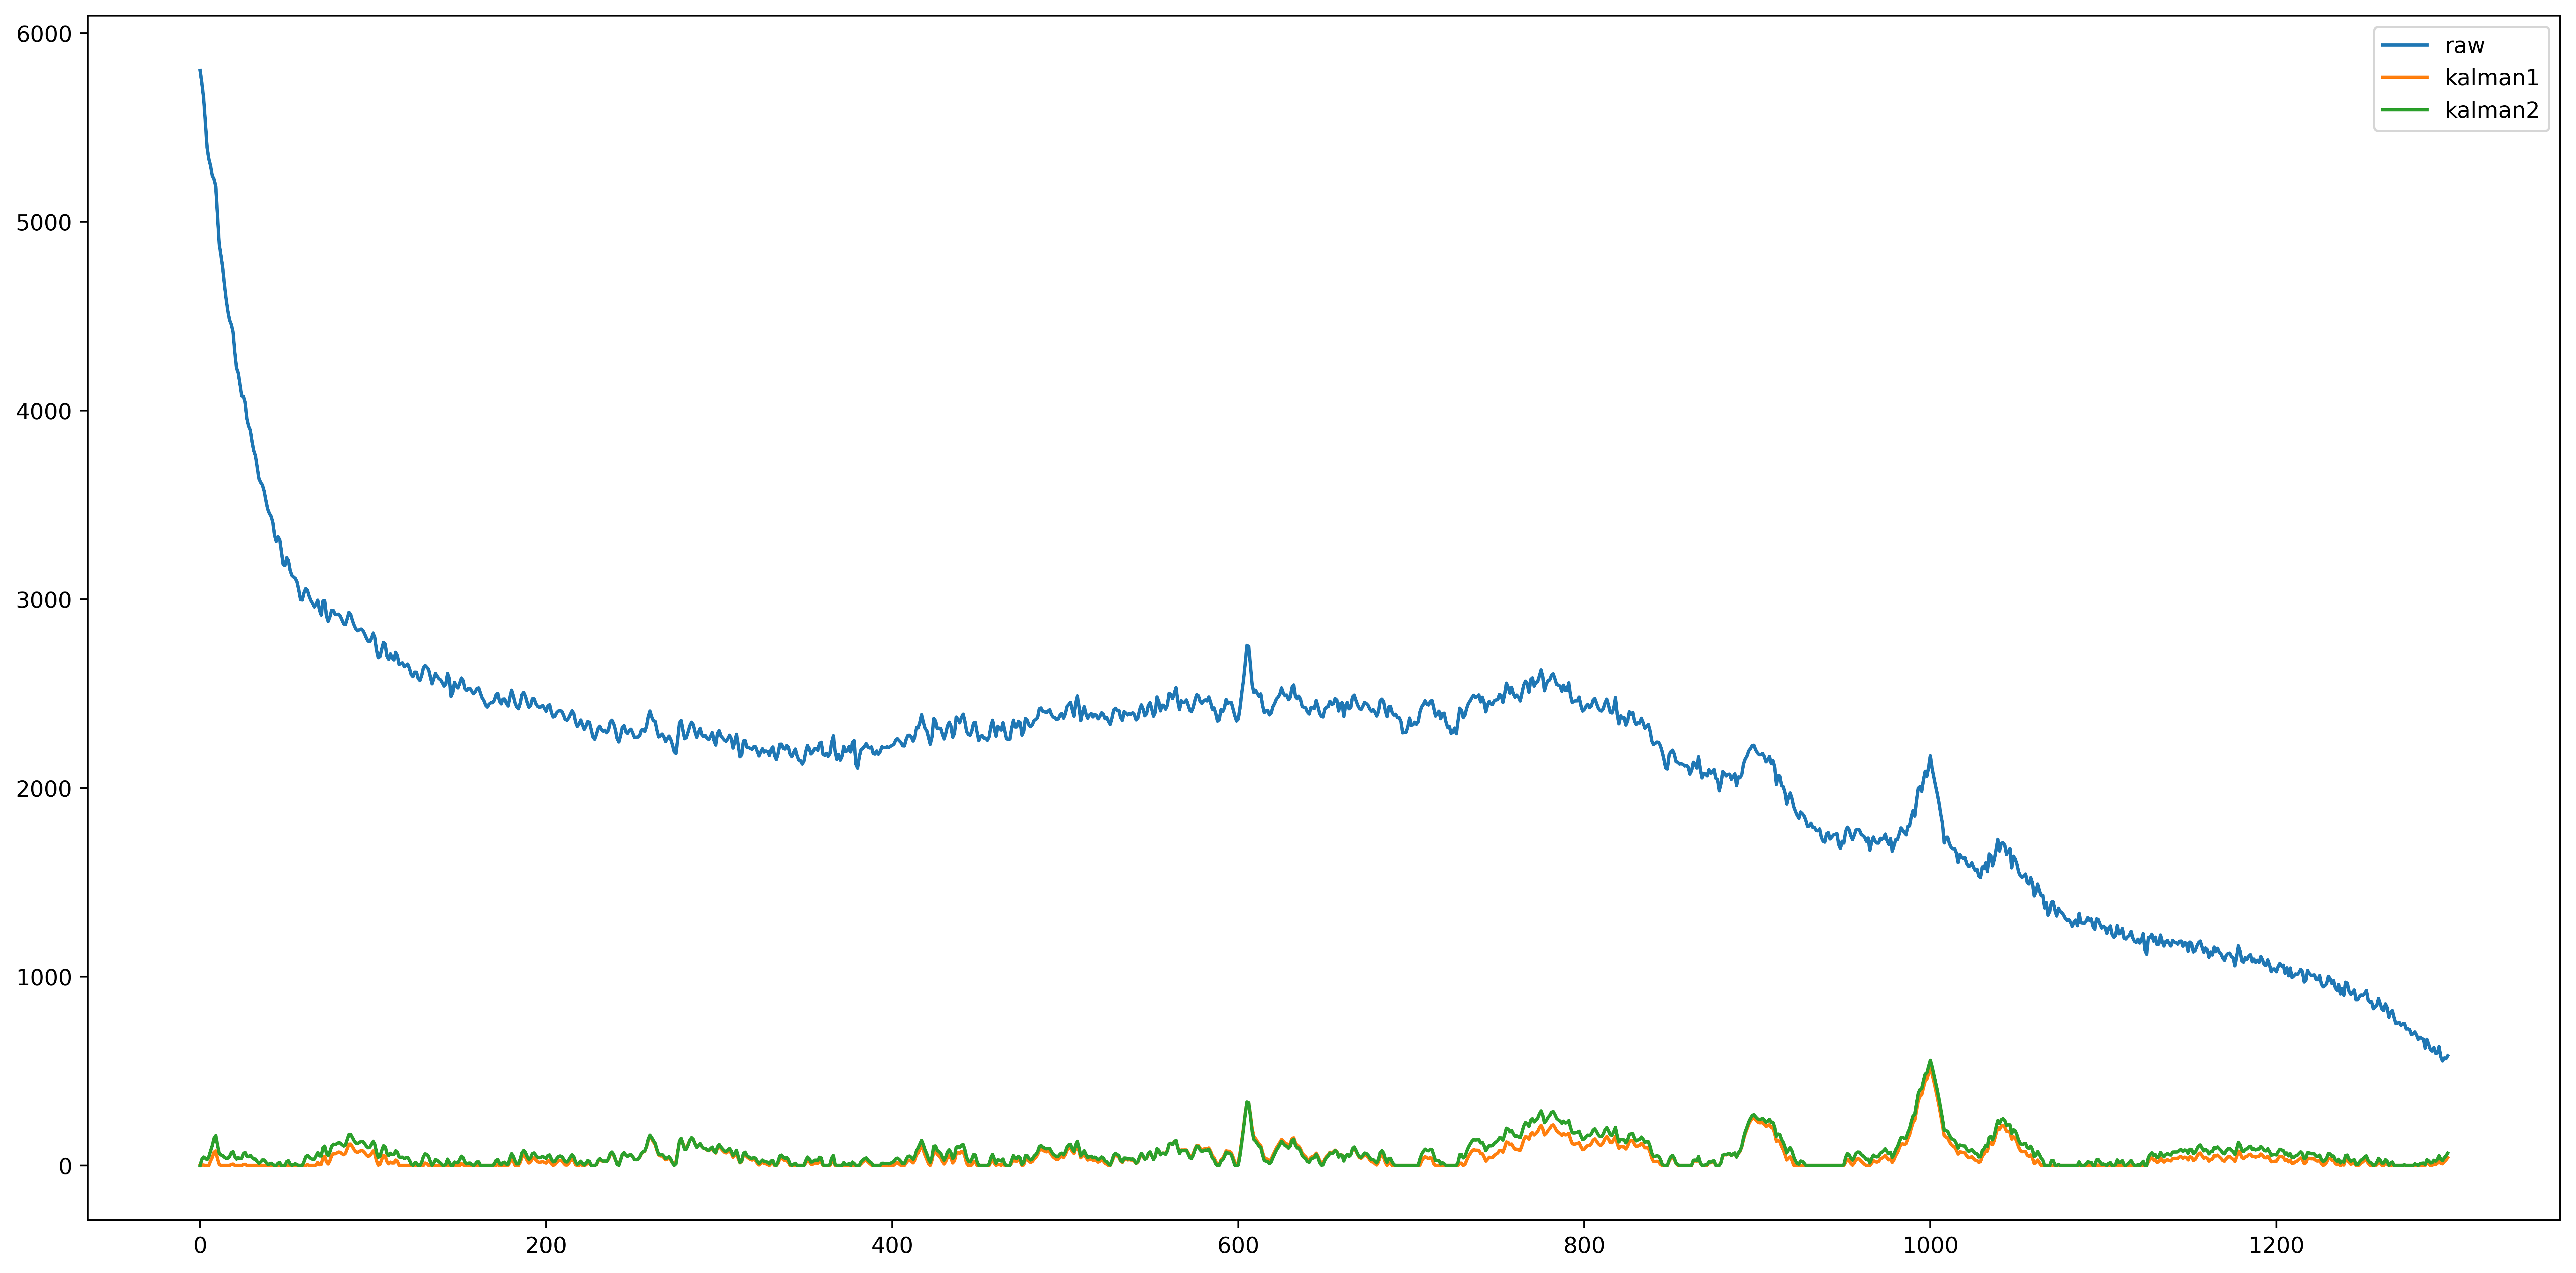

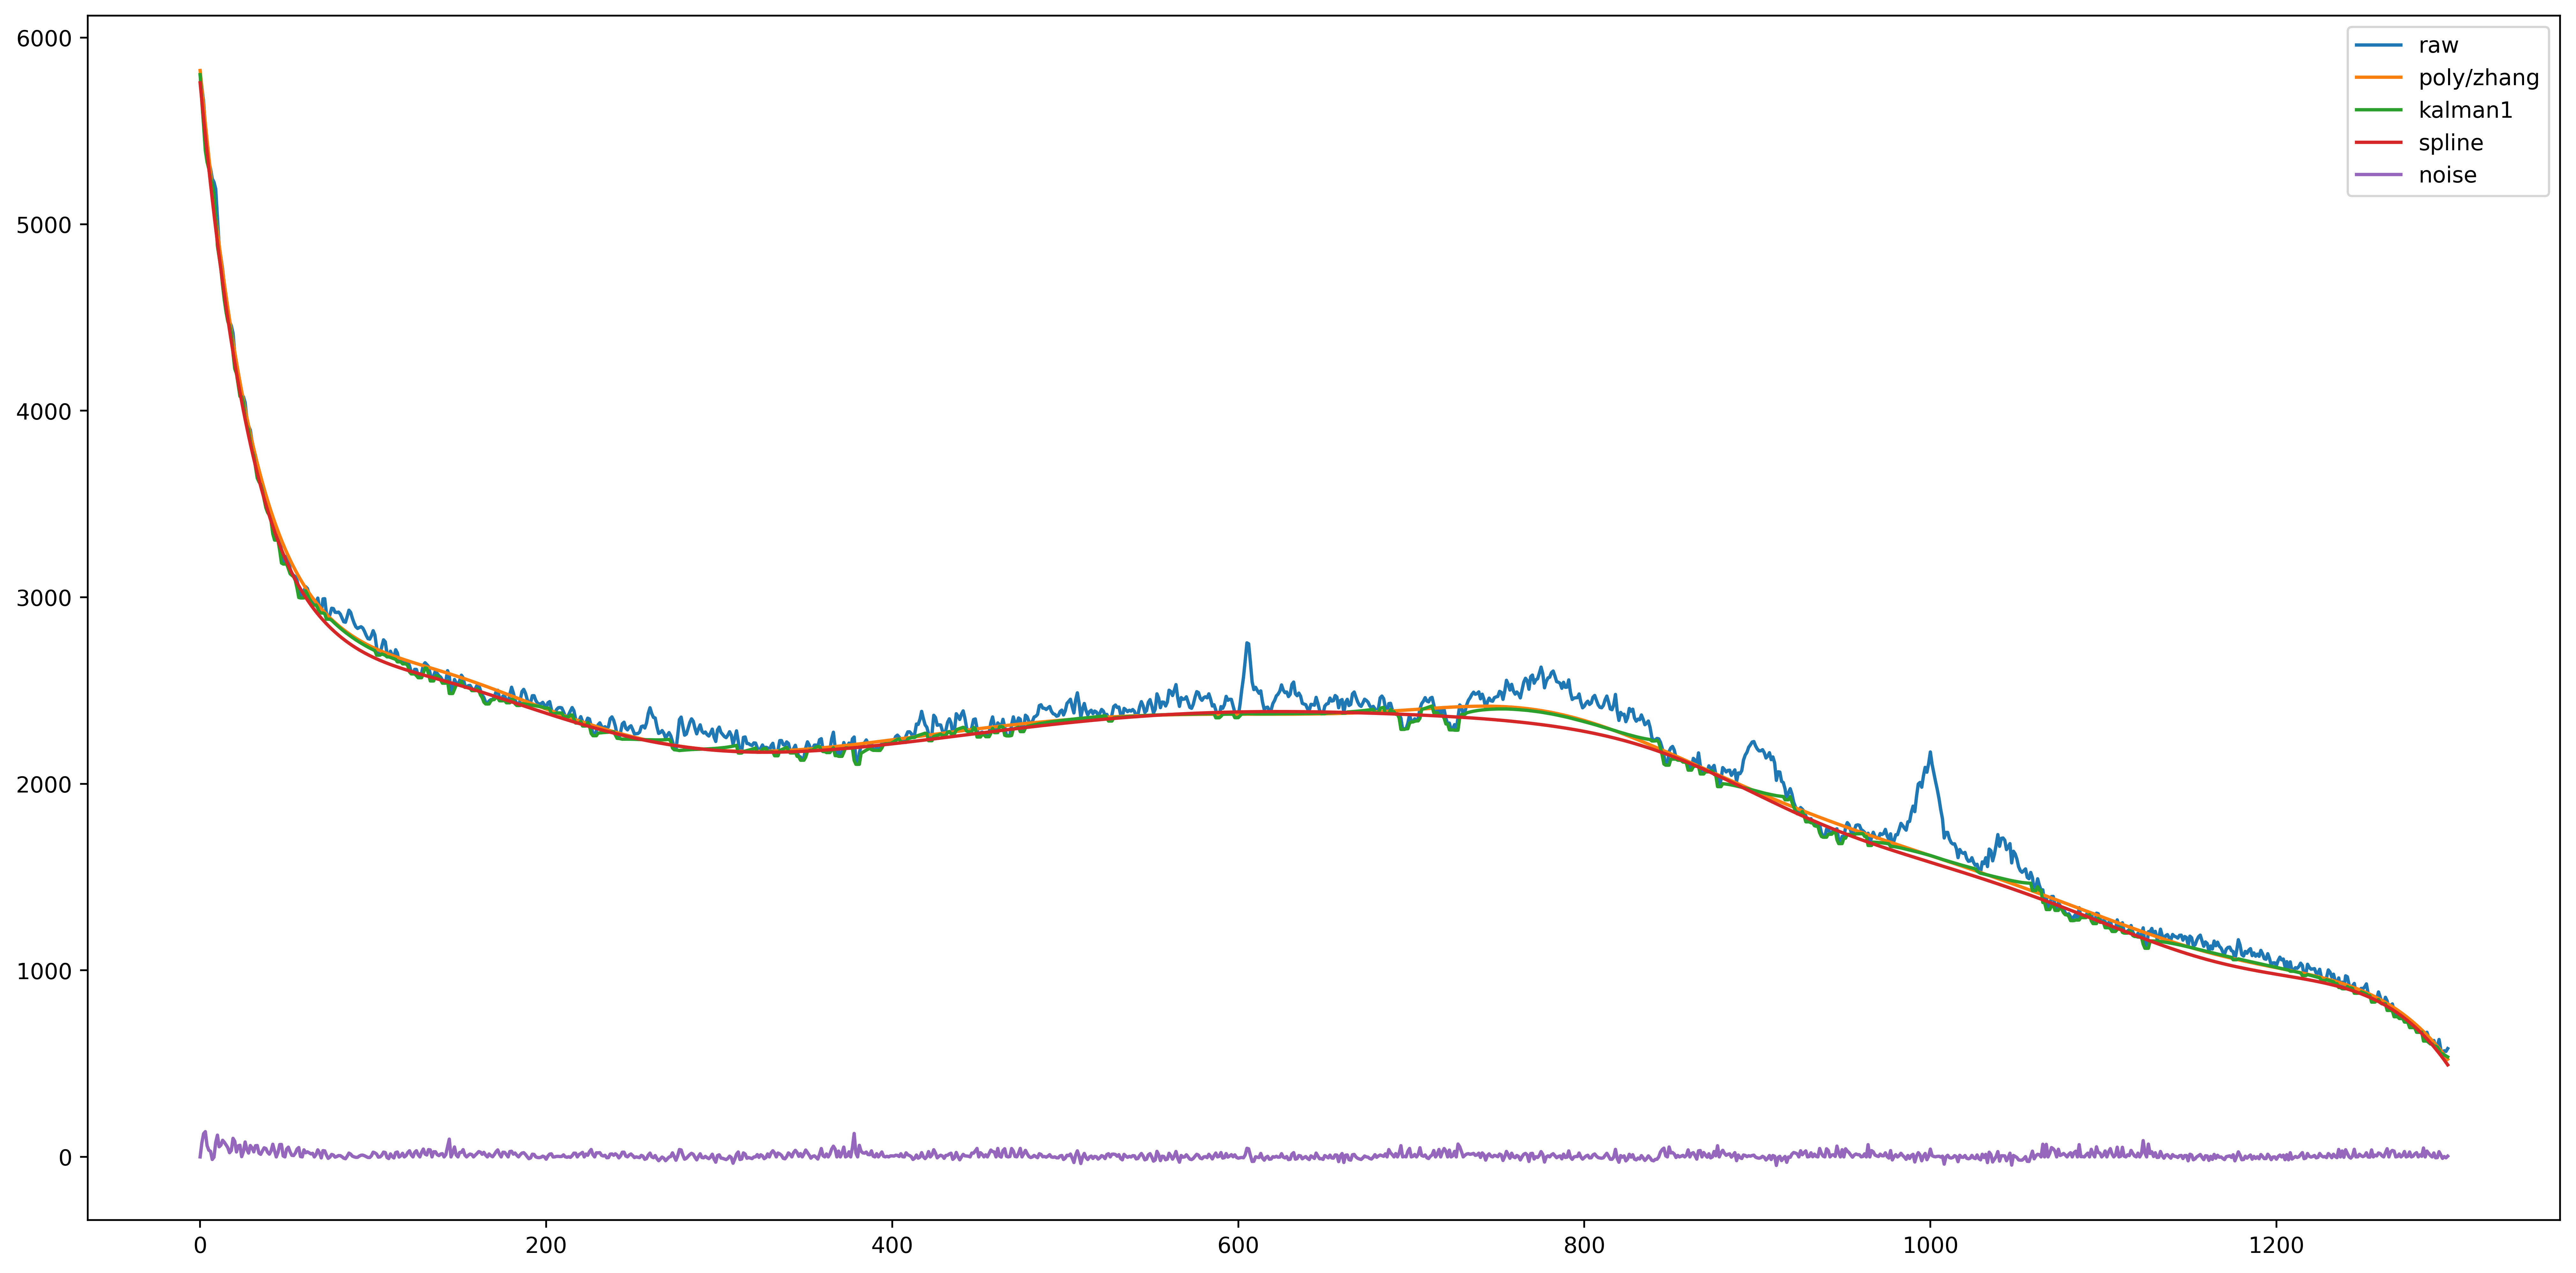

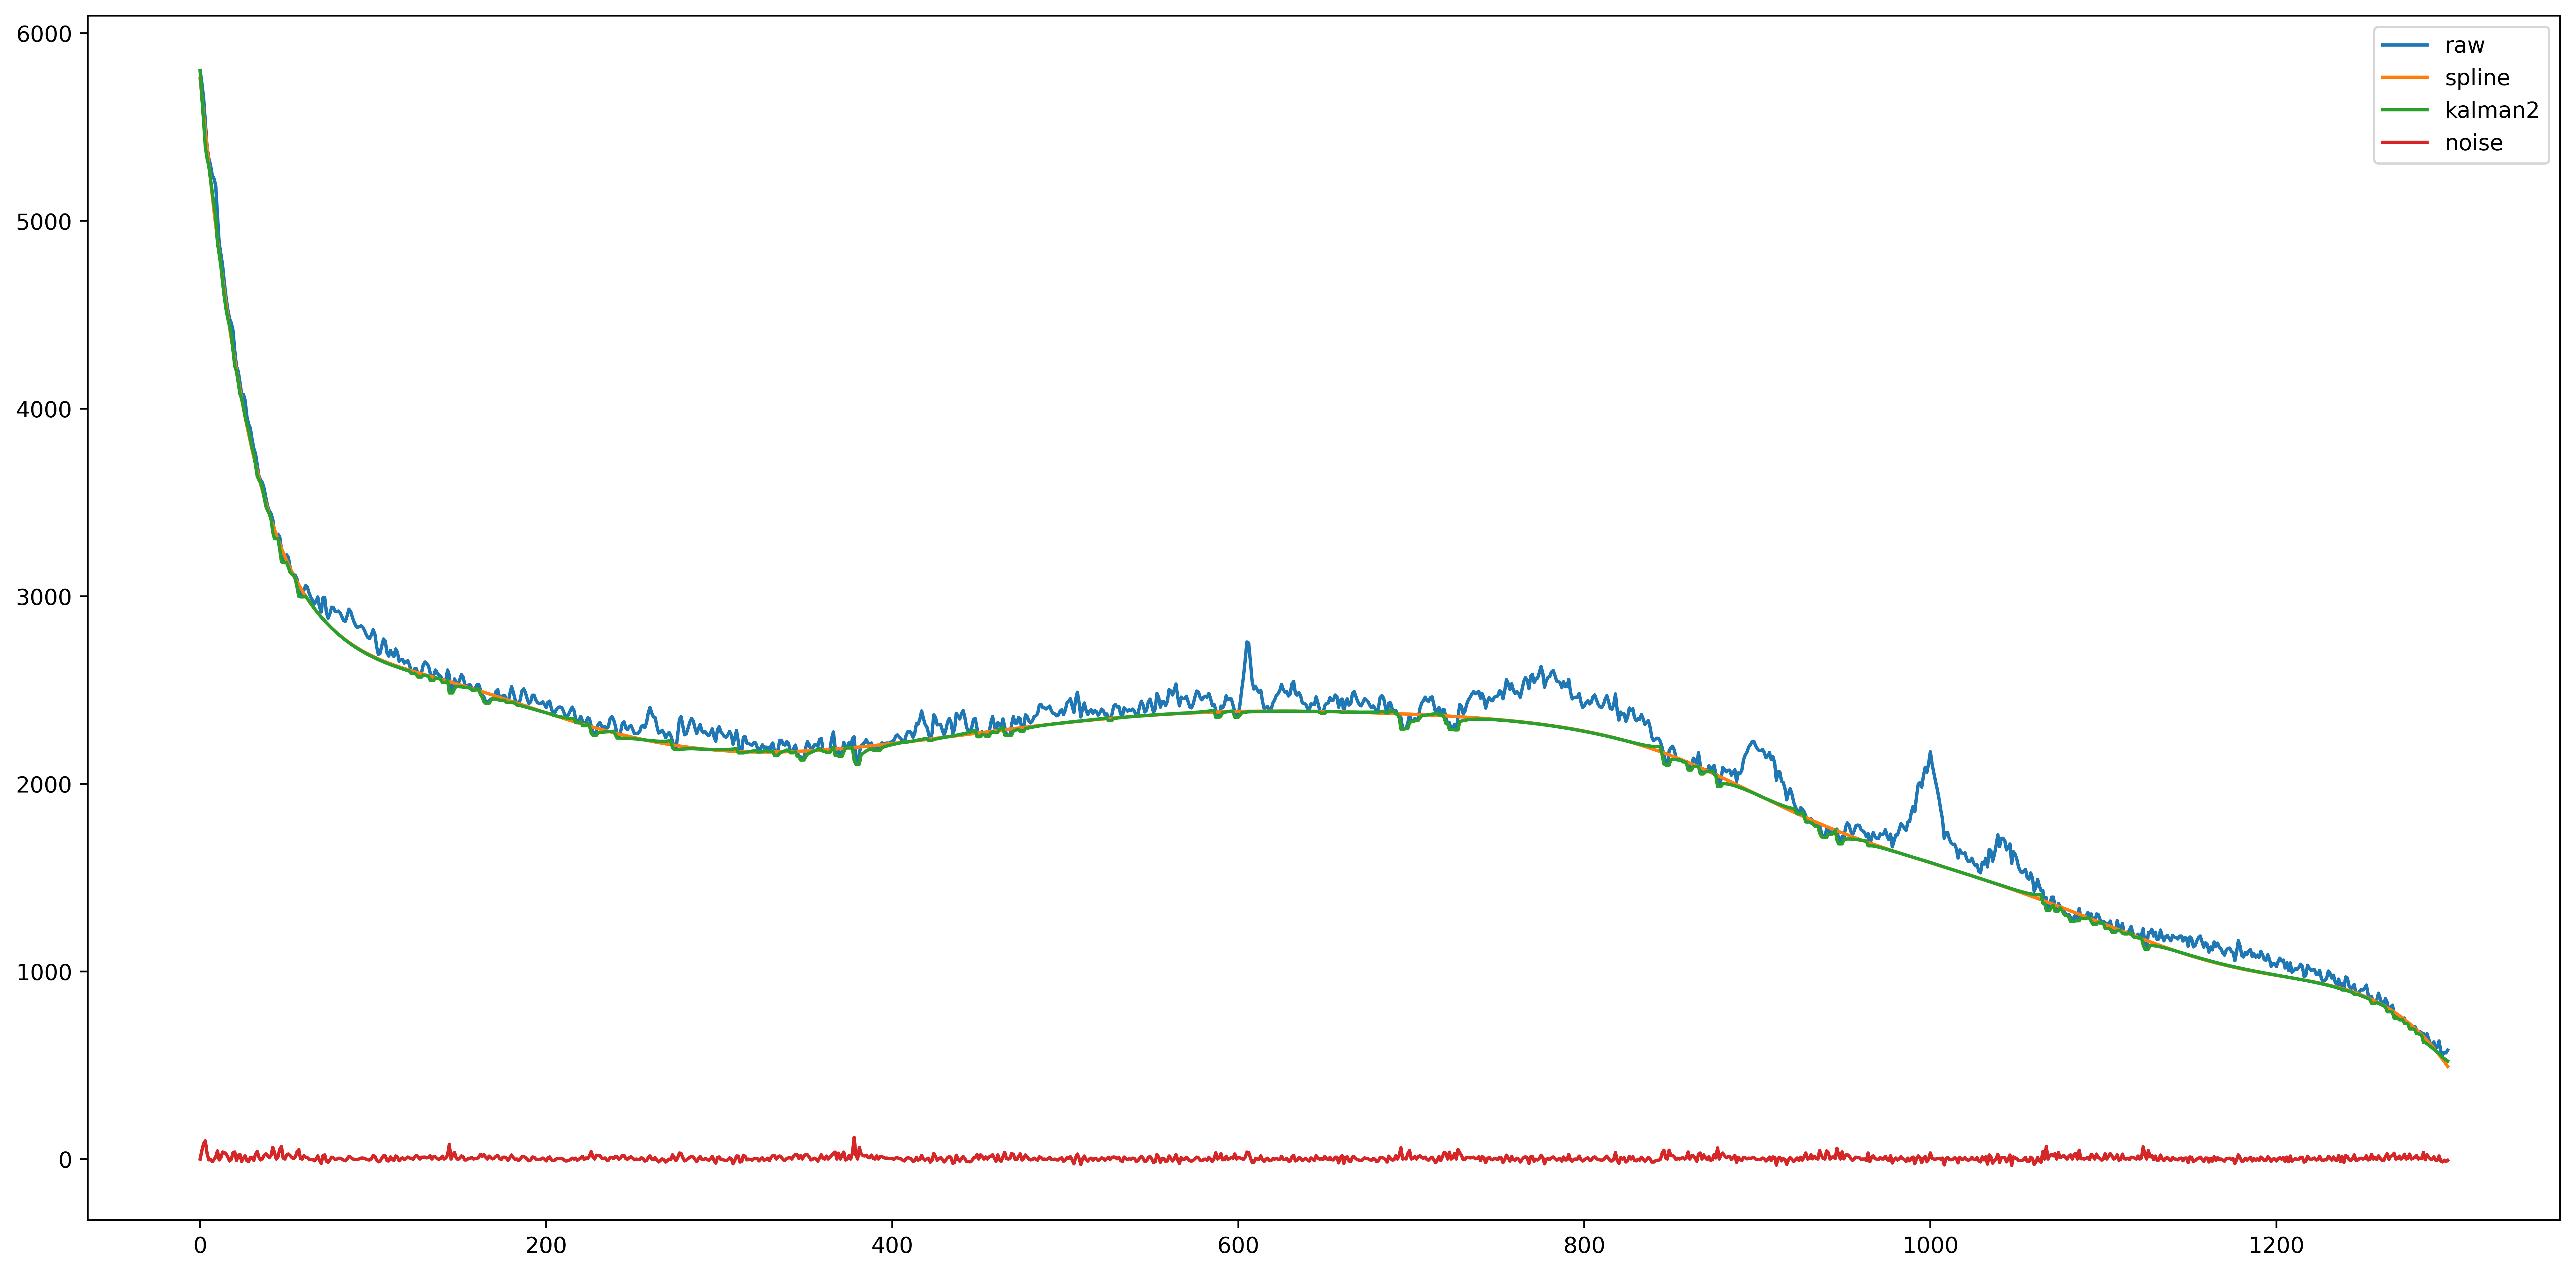

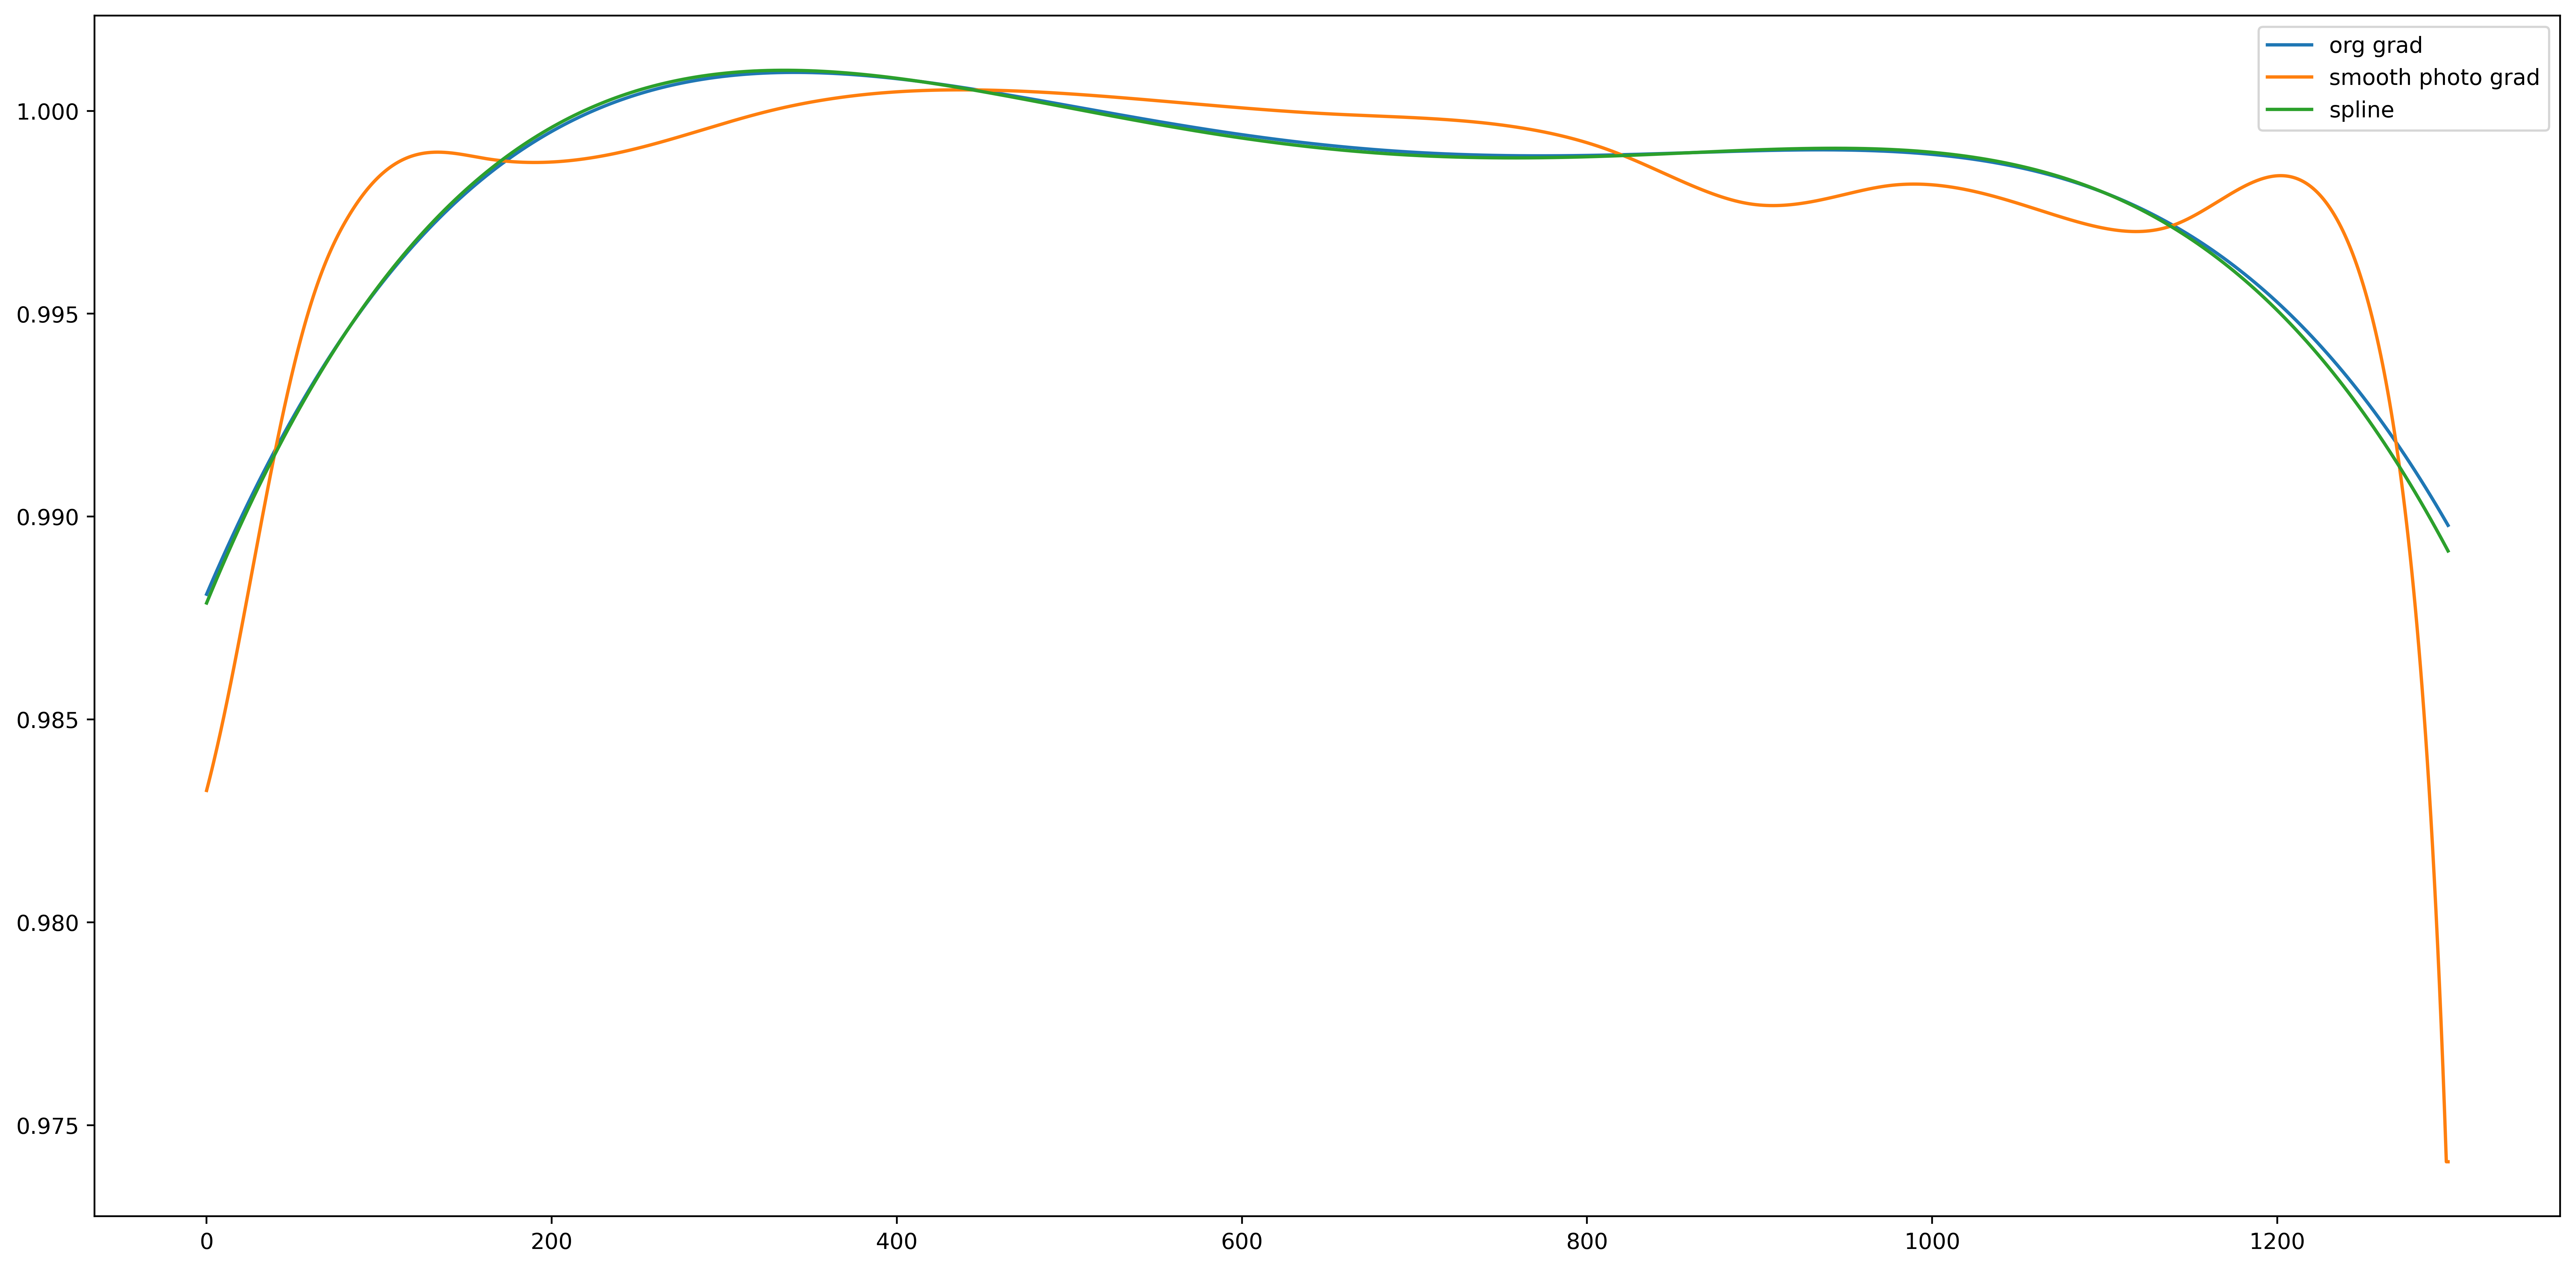

TypeError: cannot unpack non-iterable NoneType object

In [9]:
import timeit
from os import path

file_location2 = f"{'/'.join(file_location.split('/')[:-2])}/approximated/"
os.makedirs(file_location2, exist_ok=True)

shape = data[0][0].shape

for j, (f, img) in enumerate(zip(filenames, data)):   
    start = timeit.default_timer()
#     if path.exists(f'{file_location2}{f.split("/")[-1].split(".")[0]}_raman.npy'):
#         print(f'file already exist {file_location2}{f.split("/")[-1].split(".")[0]}_raman')
#         continue

    raman, photo = split_signal(img)

    stop = timeit.default_timer()
    print('Time: ', stop - start)  
    
    np.save(f'{file_location2}{f.split("/")[-1].split(".")[0]}_raman', raman.reshape(shape))
    np.save(f'{file_location2}{f.split("/")[-1].split(".")[0]}_photoluminescence', photo.reshape(shape))
    print(f"image: {f} is done.")

In [ ]:
img = img[0].reshape(-1,7500)

In [ ]:
# pixel 89 is weird
n= np.random.randint(384)
# n=7
print(n)
plt.plot(img[n], label="raw")
plt.plot(raman[n], label="raman")
plt.plot(photo[n], label="photo")
baseObj = BaselineRemoval(img[n])
Zhangfit_output = baseObj.ZhangFit()
plt.plot(img[n]-Zhangfit_output, label="zhang photo")
plt.legend()
plt.show()

135


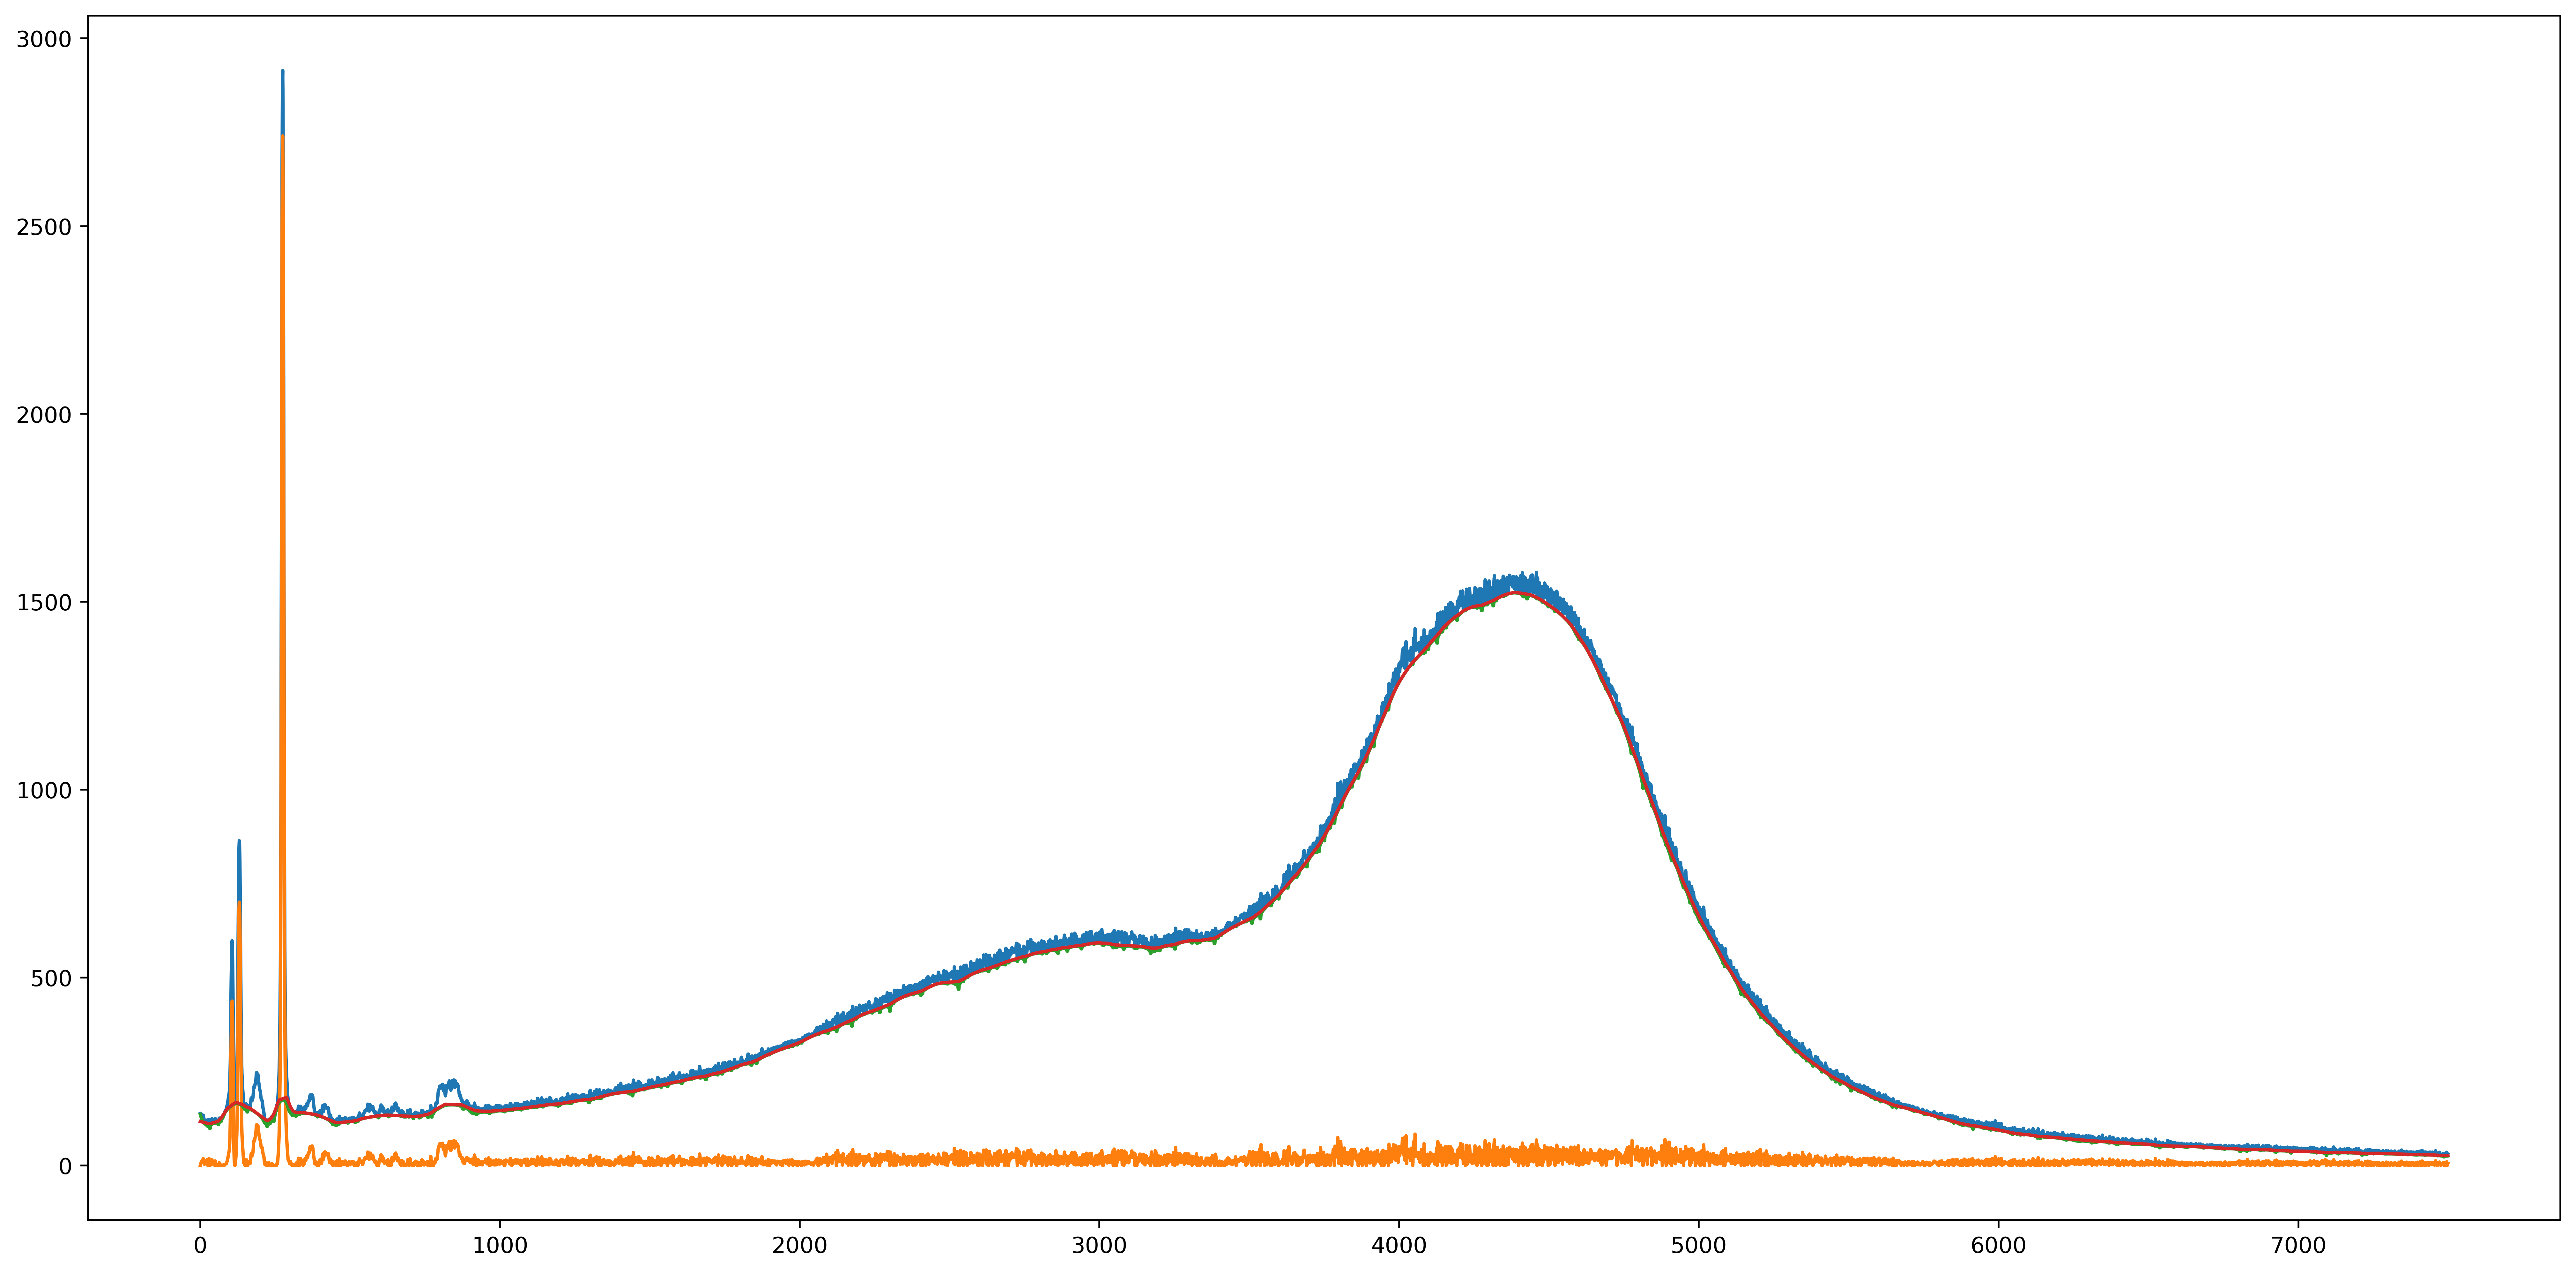

In [25]:
# both zhang and poly

n= np.random.randint(384)
print(n)
plt.plot(img[n])
plt.plot(raman[n])
plt.plot(photo[n])
baseObj = BaselineRemoval(img[n])
Zhangfit_output = baseObj.ZhangFit()
plt.plot(img[n]-Zhangfit_output)
plt.show()